In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt 
import matplotlib.pyplot as plt
import pmdarima as pm
import warnings
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import t, gennorm

In [2]:
# Define the ticker symbol for the Shanghai Composite Index
ticker = '000001.SS'

# Define the date range
start_date = '2014-01-01'
end_date = '2024-01-01'

# Download the full dataset sourced from yahoo finance
data = yf.download(ticker, start=start_date, end=end_date)

# Print some samples
print(pd.concat([data.head(1), data.tail(1)]))


[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2014-01-02  2112.125977  2113.110107  2101.016113  2109.386963  2109.386963   
2023-12-29  2950.836914  2975.031982  2950.017090  2974.935059  2974.935059   

            Volume  
Date                
2014-01-02   68500  
2023-12-29  290700  


Train: 1944, Test: 487


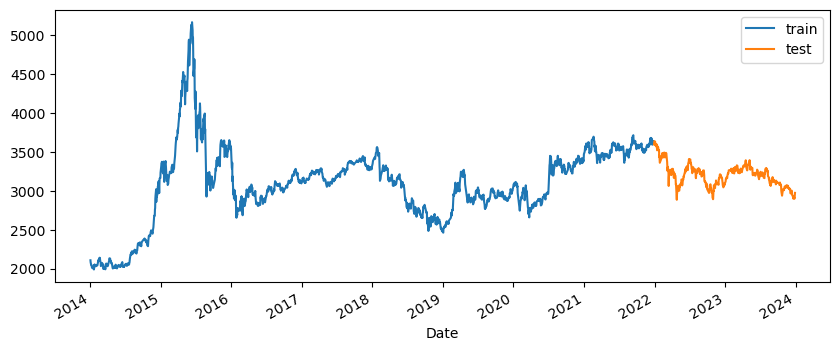

In [3]:
# Define a function for train-test split
def train_test_split(X, size=0.8):
    train = X[:int(X.shape[0]*size)]
    test = X[int(X.shape[0]*size):]
    return train, test

# Split train set and test set
train, test = train_test_split(X=data['Close'], size=0.8)
print(f'Train: {len(train)}, Test: {len(test)}')

# Plot train & test datasets 
fig, ax = plt.subplots(figsize=(10,4))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
ax.legend()
plt.show()

In [4]:
# Suppress specific warning messages
warnings.filterwarnings("ignore", category=UserWarning, module='statsmodels')

1-day Ahead Forecast using Standard Normal distribution:
MAE: 45.32472599073219
RMSE: 61.23600467644467
MAPE: 1.4244907866878493%

1-day Ahead Forecast using Student's t-distribution:
MAE: 52.752935613662416
RMSE: 75.65481721678323
MAPE: 1.6552645960167631%

1-day Ahead Forecast using Generalized Error Distribution:
MAE: 43.75042081444446
RMSE: 57.46750319674121
MAPE: 1.373166606074873%



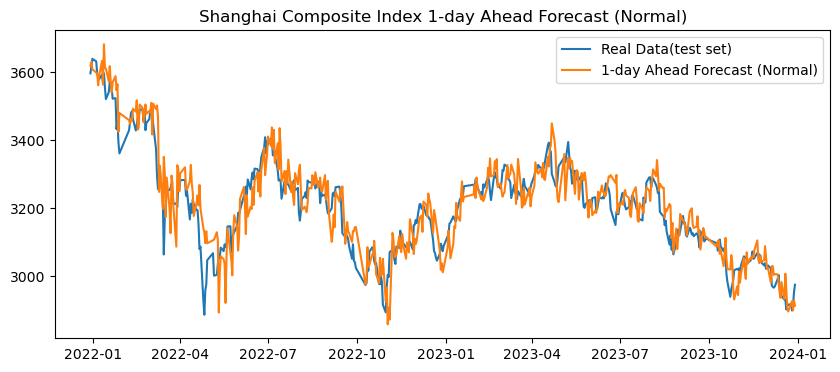

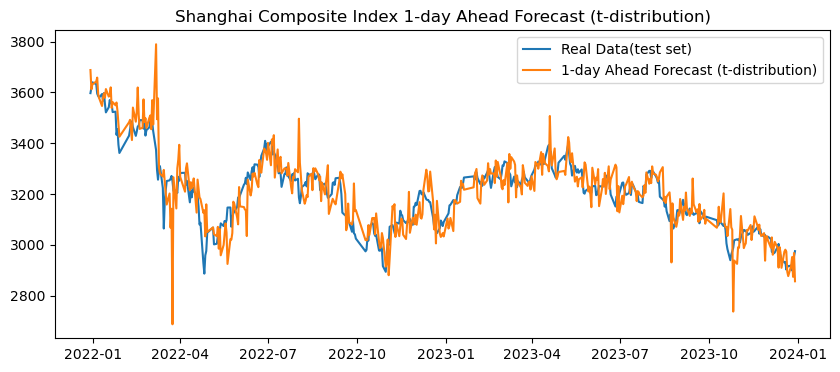

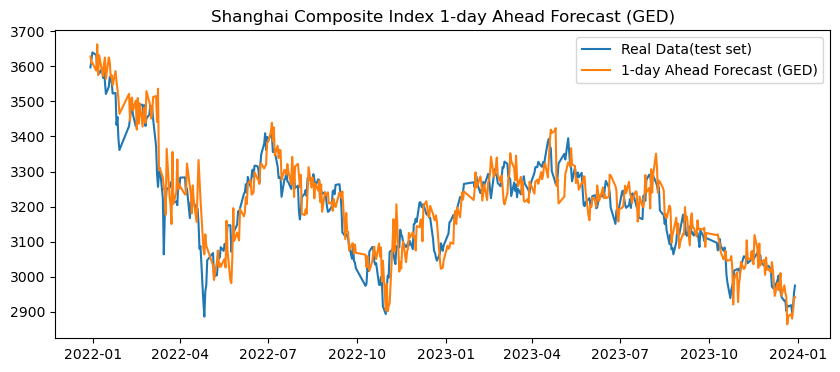

5-days Ahead Forecast using Standard Normal distribution:
MAE: 46.80685429036723
RMSE: 62.40513288072381
MAPE: 1.4677013914438624%

5-days Ahead Forecast using Student's t-distribution:
MAE: 53.79762793089496
RMSE: 72.60559996943904
MAPE: 1.6876280498059755%

5-days Ahead Forecast using Generalized Error Distribution:
MAE: 44.558739430671324
RMSE: 59.000248747894915
MAPE: 1.3979064855646717%



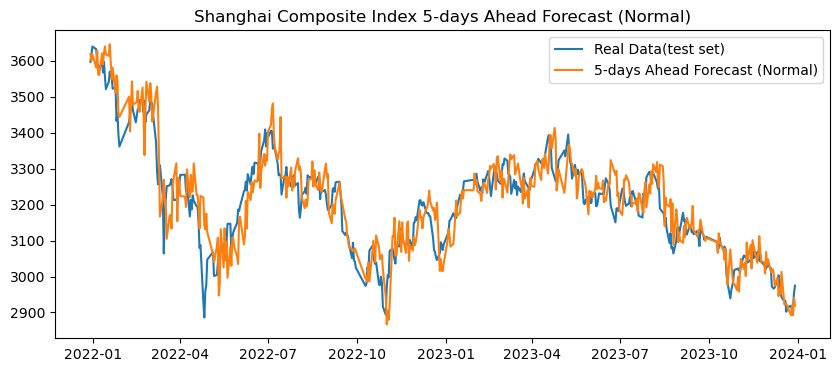

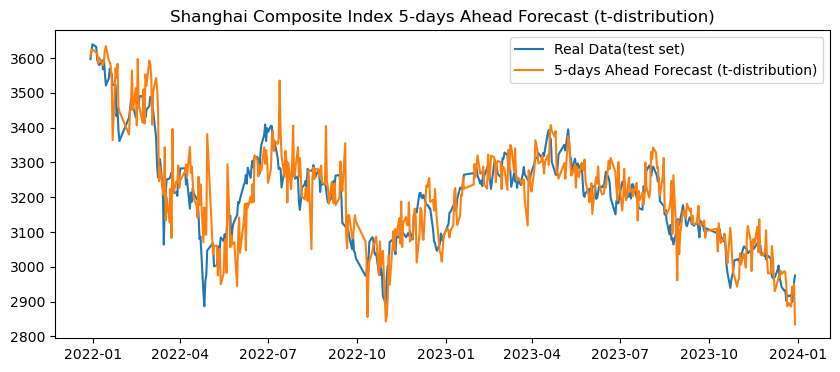

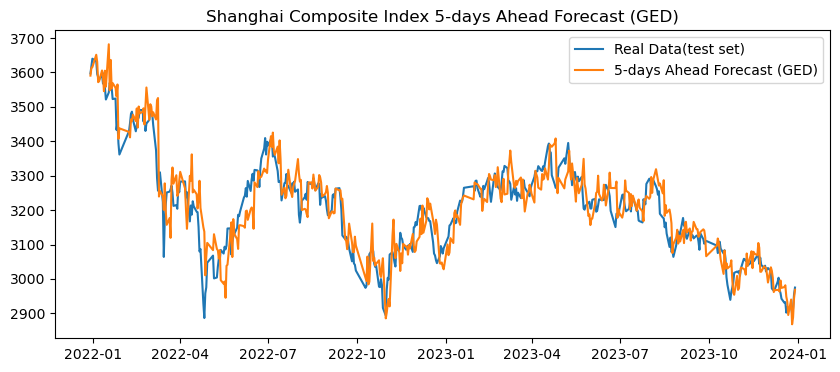

20-days Ahead Forecast using Standard Normal distribution:
MAE: 76.1229503809173
RMSE: 103.2301949335838
MAPE: 2.3893954560020427%

20-days Ahead Forecast using Student's t-distribution:
MAE: 81.48107287197429
RMSE: 111.51675888315214
MAPE: 2.5639146350821895%

20-days Ahead Forecast using Generalized Error Distribution:
MAE: 75.47333057820691
RMSE: 101.68807611116435
MAPE: 2.3711066279078987%



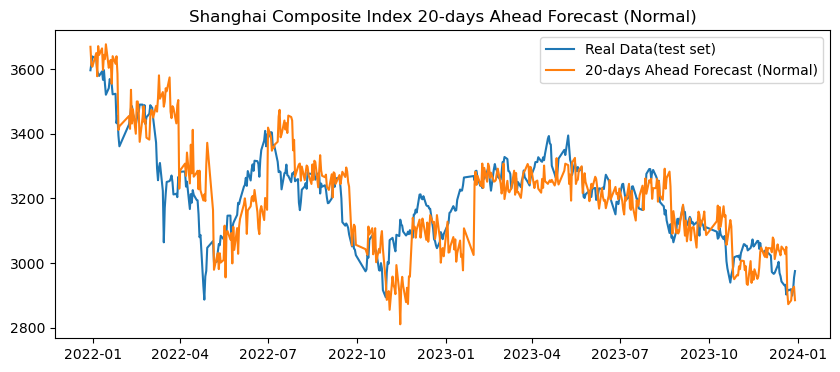

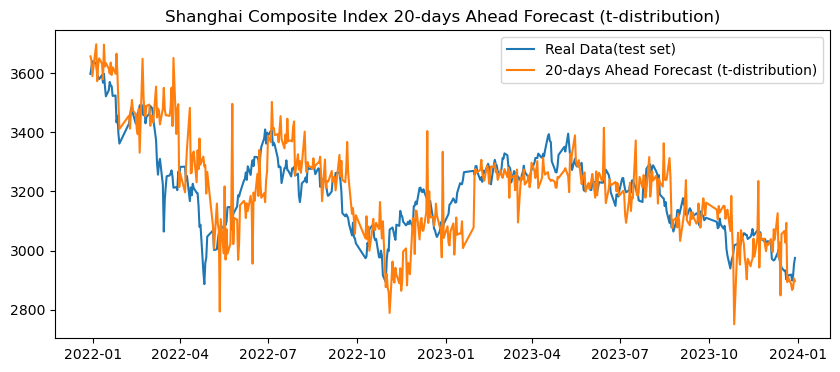

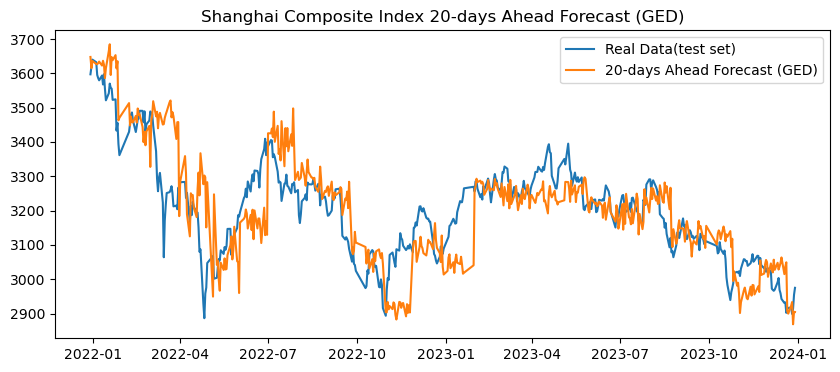

60-days Ahead Forecast using Standard Normal distribution:
MAE: 117.77876002479002
RMSE: 150.31259335618216
MAPE: 3.6837245191110144%

60-days Ahead Forecast using Student's t-distribution:
MAE: 122.05868529056578
RMSE: 159.2720253347793
MAPE: 3.8193668330415793%

60-days Ahead Forecast using Generalized Error Distribution:
MAE: 115.47504554697836
RMSE: 149.5547207651966
MAPE: 3.609164320664704%



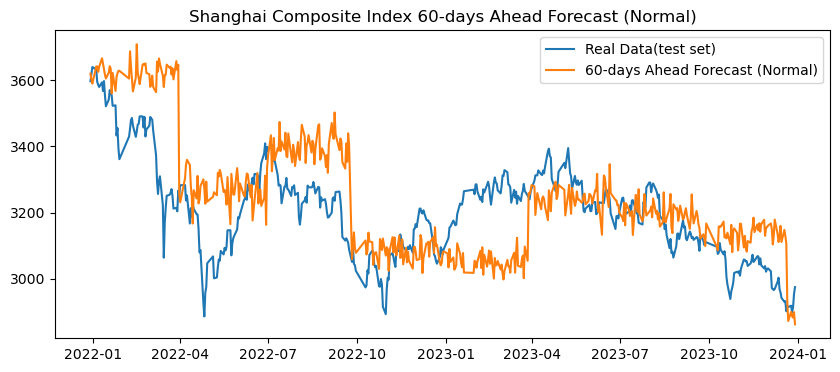

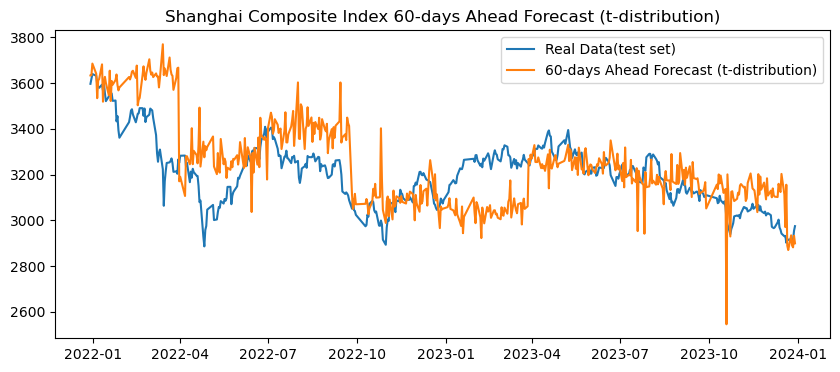

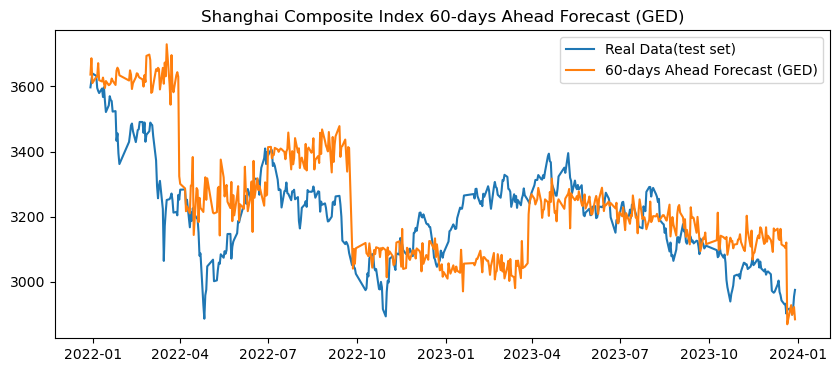

In [6]:
# Function to perform multi-step forecast with specific confidence level
def multi_step_forecast(arima_model, garch_results, n_periods, alpha=0.05):
    arima_forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True, alpha=alpha)
    garch_summary = garch_results.forecast(horizon=n_periods)
    # Extract the conditional variance
    garch_variance = garch_summary.variance.iloc[0, :n_periods].values.tolist()
    garch_forecast = np.sqrt(garch_variance)
    
    return (
        arima_forecast.tolist(),
        np.asarray(conf_int).tolist(),
        garch_forecast
    )

def reestimate_models(current_train):
    # Re-estimate the ARIMA model with the current training data
    arima_model = auto_arima(current_train, trace=False, error_action='ignore', suppress_warnings=True)
    arima_residuals = arima_model.resid()

    # Replace the first residual
    arima_residuals.iloc[0] = np.mean(arima_residuals[1:])  

    # Re-fit the GARCH model on the adjusted ARIMA residuals
    garch_results = arch_model(arima_residuals, vol='Garch', p=1, q=1).fit(disp="off")
    
    return arima_model, garch_results

# Perform forecasts and evaluations for different periods
forecast_periods = {'1-day': 1, '5-days': 5, '20-days': 20, '60-days': 60}
results = {}

# Add the Standard Normal, Student's t-distribution, and GED to the forecasts
results_with_distributions = {}

for period_name, n_periods in forecast_periods.items():
    # Define the ARIMA model and GARCH model for each time horizon
    current_train = train.copy()
    arima_model, garch_results = reestimate_models(current_train)
    
    # For daily forecast, we choose to re-estimate parameters every 5 forecasts
    reestimate_interval = 5 if period_name == '1-day' else 1
    forecasts_since_last_reestimate = 0
    
    # Creat empty lists for storing results
    arima_predictions = []
    garch_predictions = []

    for i in range(0, len(test), n_periods):
        # Perform multi-step forecast
        arima_forecast_95, conf_95, garch_forecast_95 = multi_step_forecast(arima_model, garch_results, n_periods, alpha=0.05)
        
        for j in range(n_periods):
            if i + j < len(test):
                # Store results
                arima_predictions.append(arima_forecast_95[j])
                garch_predictions.append(garch_forecast_95[j])

        # Update the training sets with new observed data
        current_train = pd.concat([current_train, test[i:i+n_periods]])

        # Re-estimate the ARIMA and GARCH models with the updated training sets
        forecasts_since_last_reestimate += 1
        if forecasts_since_last_reestimate >= reestimate_interval:
            arima_model, garch_results = reestimate_models(current_train)
            forecasts_since_last_reestimate = 0
    # Rearrange the results
    arima_forecast_series = pd.Series(arima_predictions[:len(test)], index=test.index[:len(arima_predictions)])
    garch_forecast_series = pd.Series(garch_predictions[:len(test)], index=test.index[:len(arima_predictions)])

    # Standard Normal distribution
    normal_random_shocks = np.random.normal(size=len(garch_forecast_series))
    final_forecast_normal = arima_forecast_series + garch_forecast_series * normal_random_shocks

    # Student's t-distribution with 3 degrees of freedom
    t_random_shocks = t(df=3).rvs(len(garch_forecast_series))
    final_forecast_t = arima_forecast_series + garch_forecast_series * t_random_shocks

    # Generalized Error Distribution (GED) with shape parameter (p=1.5 for heavy tails)
    ged_random_shocks = gennorm(beta=1.5).rvs(len(garch_forecast_series))
    final_forecast_ged = arima_forecast_series + garch_forecast_series * ged_random_shocks

    # Evaluate the Forecasts with different distributions
    mae_normal = mean_absolute_error(test[:len(final_forecast_normal)], final_forecast_normal)
    rmse_normal = np.sqrt(mean_squared_error(test[:len(final_forecast_normal)], final_forecast_normal))
    mape_normal = np.mean(np.abs((test[:len(final_forecast_normal)] - final_forecast_normal) / test[:len(final_forecast_normal)])) * 100

    mae_t = mean_absolute_error(test[:len(final_forecast_t)], final_forecast_t)
    rmse_t = np.sqrt(mean_squared_error(test[:len(final_forecast_t)], final_forecast_t))
    mape_t = np.mean(np.abs((test[:len(final_forecast_t)] - final_forecast_t) / test[:len(final_forecast_t)])) * 100

    mae_ged = mean_absolute_error(test[:len(final_forecast_ged)], final_forecast_ged)
    rmse_ged = np.sqrt(mean_squared_error(test[:len(final_forecast_ged)], final_forecast_ged))
    mape_ged = np.mean(np.abs((test[:len(final_forecast_ged)] - final_forecast_ged) / test[:len(final_forecast_ged)])) * 100

    # Store results
    results_with_distributions[period_name] = {
        'normal_forecast': final_forecast_normal,
        't_forecast': final_forecast_t,
        'ged_forecast': final_forecast_ged,
        'mae_normal': mae_normal,
        'rmse_normal': rmse_normal,
        'mape_normal': mape_normal,
        'mae_t': mae_t,
        'rmse_t': rmse_t,
        'mape_t': mape_t,
        'mae_ged': mae_ged,
        'rmse_ged': rmse_ged,
        'mape_ged': mape_ged
    }

    # Print the evaluation metrics for each distribution
    print(f'{period_name.capitalize()} Ahead Forecast using Standard Normal distribution:')
    print(f'MAE: {mae_normal}')
    print(f'RMSE: {rmse_normal}')
    print(f'MAPE: {mape_normal}%\n')

    print(f'{period_name.capitalize()} Ahead Forecast using Student\'s t-distribution:')
    print(f'MAE: {mae_t}')
    print(f'RMSE: {rmse_t}')
    print(f'MAPE: {mape_t}%\n')

    print(f'{period_name.capitalize()} Ahead Forecast using Generalized Error Distribution:')
    print(f'MAE: {mae_ged}')
    print(f'RMSE: {rmse_ged}')
    print(f'MAPE: {mape_ged}%\n')

    # Plot the results for Standard Normal distribution
    plt.figure(figsize=(10, 4))
    plt.plot(test, label='Real Data(test set)')
    plt.plot(final_forecast_normal, label=f'{period_name.capitalize()} Ahead Forecast (Normal)')
    plt.title(f'Shanghai Composite Index {period_name.capitalize()} Ahead Forecast (Normal)')
    plt.legend()
    plt.show()

    # Plot the results for Student's t-distribution
    plt.figure(figsize=(10, 4))
    plt.plot(test, label='Real Data(test set)')
    plt.plot(final_forecast_t, label=f'{period_name.capitalize()} Ahead Forecast (t-distribution)')
    plt.title(f'Shanghai Composite Index {period_name.capitalize()} Ahead Forecast (t-distribution)')
    plt.legend()
    plt.show()

    # Plot the results for Generalized Error Distribution (GED)
    plt.figure(figsize=(10, 4))
    plt.plot(test, label='Real Data(test set)')
    plt.plot(final_forecast_ged, label=f'{period_name.capitalize()} Ahead Forecast (GED)')
    plt.title(f'Shanghai Composite Index {period_name.capitalize()} Ahead Forecast (GED)')
    plt.legend()
    plt.show()